# Setup

In [1]:
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_scheduler
import torch
from torch.nn.functional import softmax
import datasets
from datasets import load_dataset, Dataset
import random
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchmetrics import F1Score
import pandas as pd

# Run

### Try the model

In [2]:
tokenizer = AutoTokenizer.from_pretrained("varun-v-rao/t5-base-snli")
model = AutoModelForSequenceClassification.from_pretrained("varun-v-rao/t5-base-snli", ignore_mismatched_sizes=True)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params / 1e6:.1f}M")

/Users/barrychen/anaconda3/envs/ece1786/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/20.7k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.71k [00:00<?, ?B/s]

/Users/barrychen/anaconda3/envs/ece1786/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/894M [00:00<?, ?B/s]

Total number of parameters: 223.5M


In [3]:
def test_1(input_text):
  # Tokenize input and get model output
  inputs = tokenizer(input_text, return_tensors="pt")

  # Get logits (output for classification)
  outputs = model(**inputs)
  logits = outputs.logits

  # Convert logits to probabilities using softmax
  probs = softmax(logits, dim=1)

  # Map classes to polarity values
  polarity_values = torch.tensor([-1.0, 0.0, 1.0])

  # Calculate polarity score as the weighted sum of probabilities
  polarity_score = torch.sum(probs * polarity_values, dim=1).item()

  # Get the predicted class (optional, for reference)
  predicted_class = logits.argmax(dim=1).item()

  print(f"Predicted class: {predicted_class}")
  print(f"Polarity score: {polarity_score:.2f}")

# Positive class
input_text = "The Bitcoin market will continue to grow"
test_1(input_text)

# Neutral class
input_text = "The Bitcoin market will remain steady"
test_1(input_text)

# Negative class
input_text = "The Bitcoin market is trending down"
test_1(input_text)

Predicted class: 1
Polarity score: 0.02
Predicted class: 1
Polarity score: 0.08
Predicted class: 1
Polarity score: 0.24


### Fine tune the model

In [2]:
# Set a fixed random seed for reproducibility
random.seed(42)

# Load the dataset from Hugging Face
dataset = load_dataset("kisejin/finance_sentiment_dataset")

# Convert string labels to integers
label_mapping = {"negative": 0, "neutral": 1, "positive": 2}

# Split data by sentiment label
negative_samples = [sample for sample in dataset["train"] if sample["output"] == "negative"]
positive_samples = [sample for sample in dataset["train"] if sample["output"] == "positive"]
neutral_samples = [sample for sample in dataset["train"] if sample["output"] == "neutral"]

# Get the number of negative samples to balance
num_samples = 3000 # len(negative_samples)

# Randomly select same number of positive and neutral samples
balanced_negative_samples = random.sample(negative_samples, num_samples)
balanced_positive_samples = random.sample(positive_samples, num_samples)
balanced_neutral_samples = random.sample(neutral_samples, num_samples)

# Combine all into a new dataset
balanced_dataset = balanced_negative_samples + balanced_positive_samples + balanced_neutral_samples

# Convert 'output' field to integers
for sample in balanced_dataset:
    sample['output'] = label_mapping[sample['output']]

# Optional: Convert it to a Hugging Face dataset for compatibility
from datasets import Dataset
balanced_dataset = Dataset.from_dict({k: [d[k] for d in balanced_dataset] for k in balanced_dataset[0].keys()})

#### Trial #1

/Users/barrychen/anaconda3/envs/ece1786/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/9000 [00:00<?, ? examples/s]

/Users/barrychen/anaconda3/envs/ece1786/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
 33%|███▎      | 900/2700 [4:28:38<8:22:46, 16.76s/it] 

Epoch 1/3: train loss 1.0134, val loss 0.8170, val f1 score 0.6706


 67%|██████▋   | 1800/2700 [8:47:15<4:03:55, 16.26s/it] 

Epoch 2/3: train loss 0.6984, val loss 0.5356, val f1 score 0.7999


100%|██████████| 2700/2700 [12:55:25<00:00, 15.93s/it]   

Epoch 3/3: train loss 0.5418, val loss 0.4956, val f1 score 0.8139


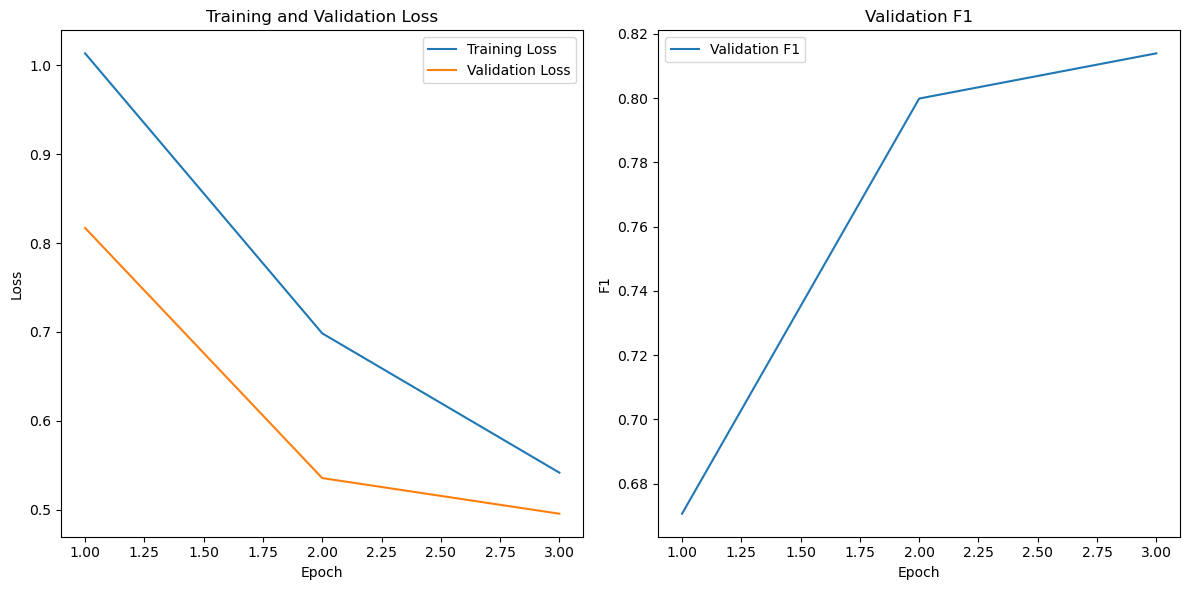

Final validation F1: 0.8139


In [5]:
# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("varun-v-rao/t5-base-snli")
model = AutoModelForSequenceClassification.from_pretrained("varun-v-rao/t5-base-snli", ignore_mismatched_sizes=True)

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["input"], padding="max_length", truncation=True, max_length=512)

# Tokenize the dataset
tokenized_datasets = balanced_dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["instruction", "input"])
tokenized_datasets = tokenized_datasets.rename_column("output", "labels")
tokenized_datasets.set_format("torch")

# Split into training and evaluation datasets
shuffled_train_dataset = tokenized_datasets.shuffle(seed=42)
train_size = int(0.8 * len(shuffled_train_dataset))  # 80% for training
small_train_dataset = shuffled_train_dataset.select(range(train_size))
small_eval_dataset = shuffled_train_dataset.select(range(train_size, len(shuffled_train_dataset)))

# Dataloaders
train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=8)
eval_dataloader = DataLoader(small_eval_dataset, batch_size=8)

# Set up optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=1e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Move model to device (GPU if available)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Initialize lists to track training/validation losses and accuracies
train_losses = []
val_losses = []
val_f1_scores = []

# Training loop
progress_bar = tqdm(range(num_training_steps))

# Initialize F1 score metric (weighted-averaged for multi-class classification)
f1_metric = F1Score(task="multiclass", num_classes=3, average="weighted").to(device)

for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0
    f1_metric.reset()
    model.train()

    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        epoch_train_loss += loss.item()
        progress_bar.update(1)

    # Record training loss for the epoch
    train_losses.append(epoch_train_loss / len(train_dataloader))

    # Evaluate the model
    model.eval()
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        loss = F.cross_entropy(logits, batch["labels"])

        epoch_val_loss += loss.item()
        f1_metric(predictions, batch["labels"])  # Update F1 metric with predictions

    # Record validation loss and accuracy
    val_losses.append(epoch_val_loss / len(eval_dataloader))
    val_f1 = f1_metric.compute().item()
    val_f1_scores.append(val_f1)

    print(f"Epoch {epoch + 1}/{num_epochs}: train loss {train_losses[-1]:.4f}, val loss {val_losses[-1]:.4f}, val f1 score {val_f1_scores[-1]:.4f}")

# Plotting function
def eval_plot(train_losses, val_losses, val_f1_scores):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))

    # Training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_f1_scores, label="Validation F1")
    plt.xlabel('Epoch')
    plt.ylabel('F1')
    plt.legend()
    plt.title('Validation F1')

    plt.tight_layout()
    plt.show()

# Plot train loss, validation loss, validation accuracy
eval_plot(train_losses, val_losses, val_f1_scores)

# Print final validation accuracy
print(f"Final validation F1: {val_f1_scores[-1]:.4f}")

In [7]:
modelsavename = "t5_9k_ep3_8139.pt"

# Save the model's state_dict
with open(modelsavename, "wb") as f:
    torch.save(model.state_dict(), f)

print(f"Model saved as {modelsavename}")

Model saved as t5_9k_ep3_8139.pt


#### Trial #2

/Users/barrychen/anaconda3/envs/ece1786/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/var/folders/vx/57ntql9x3lg7fsldp3xp6w1c0000gn/T/ipykernel_62186/2317062138.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlis

Map:   0%|          | 0/9000 [00:00<?, ? examples/s]

/Users/barrychen/anaconda3/envs/ece1786/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
 33%|███▎      | 900/2700 [3:57:32<7:43:12, 15.44s/it] 

Epoch 1/3: train loss 0.4600, val loss 0.4073, val f1 score 0.8421


 67%|██████▋   | 1800/2700 [8:04:32<3:55:14, 15.68s/it] 

Epoch 2/3: train loss 0.3689, val loss 0.3723, val f1 score 0.8590


100%|██████████| 2700/2700 [12:09:34<00:00, 15.67s/it]   

Epoch 3/3: train loss 0.3302, val loss 0.3673, val f1 score 0.8585


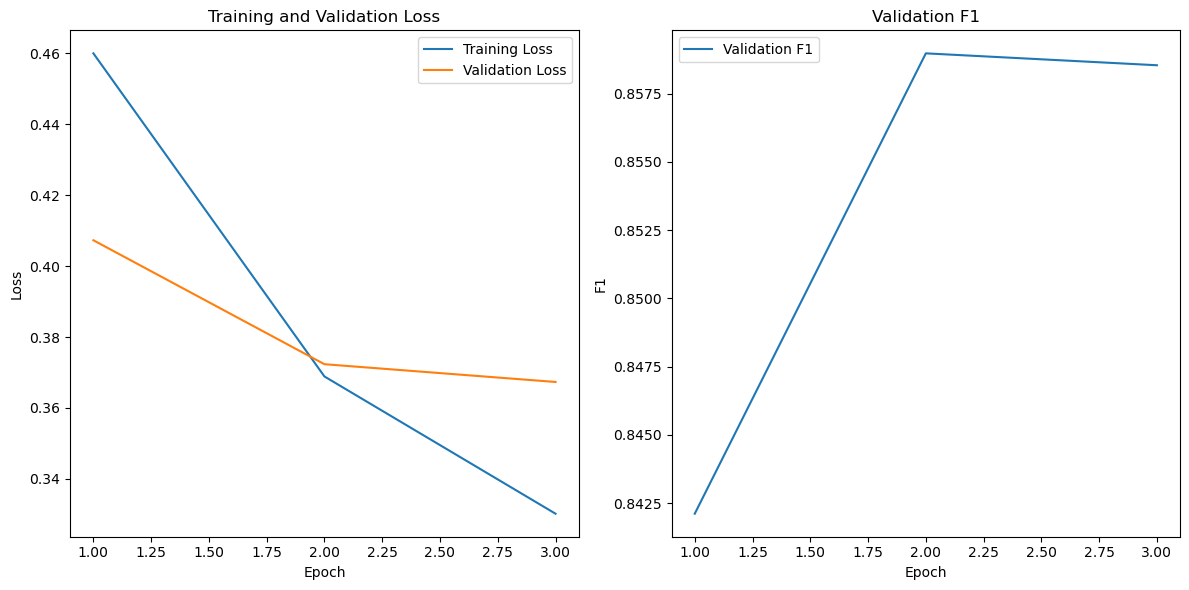

Final validation F1: 0.8585


In [3]:
# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("varun-v-rao/t5-base-snli")
model = AutoModelForSequenceClassification.from_pretrained("varun-v-rao/t5-base-snli", ignore_mismatched_sizes=True)
model.load_state_dict(torch.load("t5_9k_ep3_8139.pt"))

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["input"], padding="max_length", truncation=True, max_length=512)

# Tokenize the dataset
tokenized_datasets = balanced_dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["instruction", "input"])
tokenized_datasets = tokenized_datasets.rename_column("output", "labels")
tokenized_datasets.set_format("torch")

# Split into training and evaluation datasets
shuffled_train_dataset = tokenized_datasets.shuffle(seed=42)
train_size = int(0.8 * len(shuffled_train_dataset))  # 80% for training
small_train_dataset = shuffled_train_dataset.select(range(train_size))
small_eval_dataset = shuffled_train_dataset.select(range(train_size, len(shuffled_train_dataset)))

# Dataloaders
train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=8)
eval_dataloader = DataLoader(small_eval_dataset, batch_size=8)

# Set up optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=1e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Move model to device (GPU if available)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Initialize lists to track training/validation losses and accuracies
train_losses = []
val_losses = []
val_f1_scores = []

# Training loop
progress_bar = tqdm(range(num_training_steps))

# Initialize F1 score metric (weighted-averaged for multi-class classification)
f1_metric = F1Score(task="multiclass", num_classes=3, average="weighted").to(device)

for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0
    f1_metric.reset()
    model.train()

    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        epoch_train_loss += loss.item()
        progress_bar.update(1)

    # Record training loss for the epoch
    train_losses.append(epoch_train_loss / len(train_dataloader))

    # Evaluate the model
    model.eval()
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        loss = F.cross_entropy(logits, batch["labels"])

        epoch_val_loss += loss.item()
        f1_metric(predictions, batch["labels"])  # Update F1 metric with predictions

    # Record validation loss and accuracy
    val_losses.append(epoch_val_loss / len(eval_dataloader))
    val_f1 = f1_metric.compute().item()
    val_f1_scores.append(val_f1)

    print(f"Epoch {epoch + 1}/{num_epochs}: train loss {train_losses[-1]:.4f}, val loss {val_losses[-1]:.4f}, val f1 score {val_f1_scores[-1]:.4f}")

# Plotting function
def eval_plot(train_losses, val_losses, val_f1_scores):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))

    # Training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_f1_scores, label="Validation F1")
    plt.xlabel('Epoch')
    plt.ylabel('F1')
    plt.legend()
    plt.title('Validation F1')

    plt.tight_layout()
    plt.show()

# Plot train loss, validation loss, validation accuracy
eval_plot(train_losses, val_losses, val_f1_scores)

# Print final validation accuracy
print(f"Final validation F1: {val_f1_scores[-1]:.4f}")

#### Trial #3 (encoder-only)

/Users/barrychen/anaconda3/envs/ece1786/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/9000 [00:00<?, ? examples/s]

/Users/barrychen/anaconda3/envs/ece1786/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
 33%|███▎      | 900/2700 [1:28:24<2:57:36,  5.92s/it]

Epoch 1/3: train loss 1.0661, val loss 1.0320, val f1 score 0.4814


 67%|██████▋   | 1800/2700 [3:01:05<1:32:10,  6.15s/it]

Epoch 2/3: train loss 1.0099, val loss 0.9850, val f1 score 0.5469


100%|██████████| 2700/2700 [4:36:10<00:00,  5.56s/it]   

Epoch 3/3: train loss 0.9720, val loss 0.9643, val f1 score 0.5710


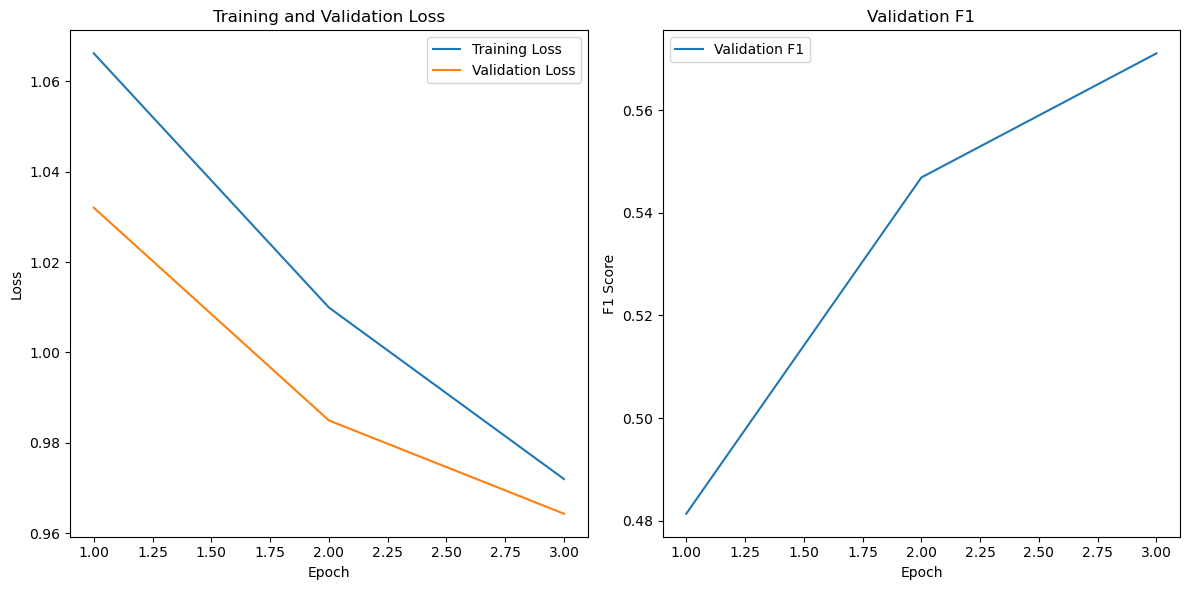

Final validation F1: 0.5710


In [3]:
# Load the tokenizer and encoder model (not decoder)
tokenizer = AutoTokenizer.from_pretrained("varun-v-rao/t5-base-snli")
encoder_model = AutoModel.from_pretrained("varun-v-rao/t5-base-snli")

class T5EncoderForClassification(torch.nn.Module):
    def __init__(self, model_name, num_labels):
        super(T5EncoderForClassification, self).__init__()
        self.encoder = encoder_model.encoder  # Use only the encoder
        self.classifier = torch.nn.Linear(self.encoder.config.d_model, num_labels)  # Classifier layer

    def forward(self, input_ids, attention_mask=None):
        # Forward pass through the encoder (only encoder, no decoder)
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        # Take the hidden state of the [CLS] token (first token in the sequence)
        cls_output = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(cls_output)  # Pass the CLS token through the classifier
        return logits

# Instantiate model
model = T5EncoderForClassification(encoder_model, num_labels=3)

# Move model to the device (GPU if available)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["input"], padding="max_length", truncation=True, max_length=512)

# Tokenize the dataset
tokenized_datasets = balanced_dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["instruction", "input"])
tokenized_datasets = tokenized_datasets.rename_column("output", "labels")
tokenized_datasets.set_format("torch")

# Split dataset into training and evaluation
shuffled_train_dataset = tokenized_datasets.shuffle(seed=42)
train_size = int(0.8 * len(shuffled_train_dataset))
small_train_dataset = shuffled_train_dataset.select(range(train_size))
small_eval_dataset = shuffled_train_dataset.select(range(train_size, len(shuffled_train_dataset)))

# Dataloaders
train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=8)
eval_dataloader = DataLoader(small_eval_dataset, batch_size=8)

# Set up optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=1e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Initialize lists to track training/validation losses and accuracies
train_losses = []
val_losses = []
val_f1_scores = []

# Initialize F1 score metric
f1_metric = F1Score(task="multiclass", num_classes=3, average="weighted").to(device)

# Training loop with updates
progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0
    f1_metric.reset()
    model.train()

    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
        
        # Compute loss using cross-entropy
        loss = F.cross_entropy(outputs, batch["labels"])
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        epoch_train_loss += loss.item()
        progress_bar.update(1)

    # Record training loss for the epoch
    train_losses.append(epoch_train_loss / len(train_dataloader))

    # Evaluate the model
    model.eval()
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])

        predictions = torch.argmax(outputs, dim=-1)
        loss = F.cross_entropy(outputs, batch["labels"])

        epoch_val_loss += loss.item()
        f1_metric(predictions, batch["labels"])  # Update F1 metric with predictions

    # Record validation loss and F1 score
    val_losses.append(epoch_val_loss / len(eval_dataloader))
    val_f1 = f1_metric.compute().item()
    val_f1_scores.append(val_f1)

    print(f"Epoch {epoch + 1}/{num_epochs}: train loss {train_losses[-1]:.4f}, val loss {val_losses[-1]:.4f}, val f1 score {val_f1_scores[-1]:.4f}")

# Plotting function
def eval_plot(train_losses, val_losses, val_f1_scores):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 6))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Plot validation F1 score
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_f1_scores, label="Validation F1")
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.title('Validation F1')

    plt.tight_layout()
    plt.show()

# Plot losses and F1 scores
eval_plot(train_losses, val_losses, val_f1_scores)

# Print final validation F1 score
print(f"Final validation F1: {val_f1_scores[-1]:.4f}")


#### Trial #4 (encoder-only)

/Users/barrychen/anaconda3/envs/ece1786/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/9000 [00:00<?, ? examples/s]

/Users/barrychen/anaconda3/envs/ece1786/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
 33%|███▎      | 900/2700 [1:29:43<2:58:14,  5.94s/it]

Epoch 1/3: train loss 0.7103, val loss 0.4208, val f1 score 0.8483


 67%|██████▋   | 1800/2700 [3:04:42<1:28:03,  5.87s/it]

Epoch 2/3: train loss 0.2751, val loss 0.3292, val f1 score 0.8837


100%|██████████| 2700/2700 [4:39:17<00:00,  6.13s/it]   

Epoch 3/3: train loss 0.1445, val loss 0.3440, val f1 score 0.8903


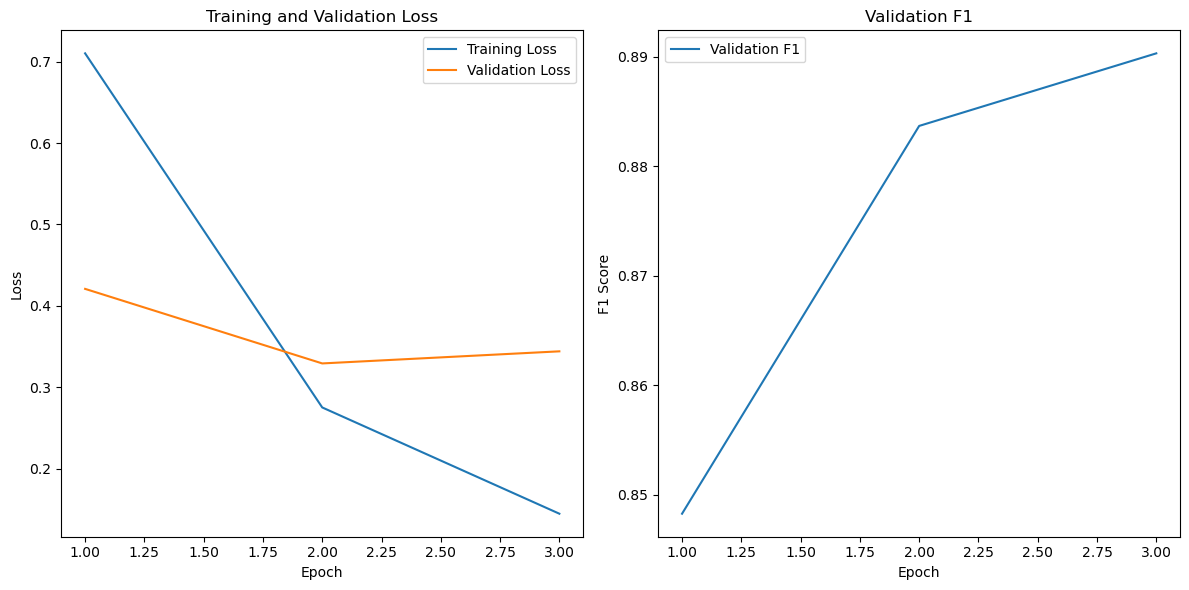

Final validation F1: 0.8903


In [3]:
# Load the tokenizer and encoder model (not decoder)
tokenizer = AutoTokenizer.from_pretrained("varun-v-rao/t5-base-snli")
encoder_model = AutoModel.from_pretrained("varun-v-rao/t5-base-snli")

class T5EncoderForClassification(torch.nn.Module):
    def __init__(self, model_name, num_labels):
        super(T5EncoderForClassification, self).__init__()
        self.encoder = encoder_model.encoder  # Use only the encoder
        self.classifier = torch.nn.Linear(self.encoder.config.d_model, num_labels)  # Classifier layer

    def forward(self, input_ids, attention_mask=None):
        # Forward pass through the encoder (only encoder, no decoder)
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        # Take the hidden state of the [CLS] token (first token in the sequence)
        cls_output = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(cls_output)  # Pass the CLS token through the classifier
        return logits

# Instantiate model
model = T5EncoderForClassification(encoder_model, num_labels=3)

# Move model to the device (GPU if available)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["input"], padding="max_length", truncation=True, max_length=512)

# Tokenize the dataset
tokenized_datasets = balanced_dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["instruction", "input"])
tokenized_datasets = tokenized_datasets.rename_column("output", "labels")
tokenized_datasets.set_format("torch")

# Split dataset into training and evaluation
shuffled_train_dataset = tokenized_datasets.shuffle(seed=42)
train_size = int(0.8 * len(shuffled_train_dataset))
small_train_dataset = shuffled_train_dataset.select(range(train_size))
small_eval_dataset = shuffled_train_dataset.select(range(train_size, len(shuffled_train_dataset)))

# Dataloaders
train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=8)
eval_dataloader = DataLoader(small_eval_dataset, batch_size=8)

# Set up optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=1e-4)
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Initialize lists to track training/validation losses and accuracies
train_losses = []
val_losses = []
val_f1_scores = []

# Initialize F1 score metric
f1_metric = F1Score(task="multiclass", num_classes=3, average="weighted").to(device)

# Training loop with updates
progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0
    f1_metric.reset()
    model.train()

    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
        
        # Compute loss using cross-entropy
        loss = F.cross_entropy(outputs, batch["labels"])
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        epoch_train_loss += loss.item()
        progress_bar.update(1)

    # Record training loss for the epoch
    train_losses.append(epoch_train_loss / len(train_dataloader))

    # Evaluate the model
    model.eval()
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])

        predictions = torch.argmax(outputs, dim=-1)
        loss = F.cross_entropy(outputs, batch["labels"])

        epoch_val_loss += loss.item()
        f1_metric(predictions, batch["labels"])  # Update F1 metric with predictions

    # Record validation loss and F1 score
    val_losses.append(epoch_val_loss / len(eval_dataloader))
    val_f1 = f1_metric.compute().item()
    val_f1_scores.append(val_f1)

    print(f"Epoch {epoch + 1}/{num_epochs}: train loss {train_losses[-1]:.4f}, val loss {val_losses[-1]:.4f}, val f1 score {val_f1_scores[-1]:.4f}")

# Plotting function
def eval_plot(train_losses, val_losses, val_f1_scores):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 6))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Plot validation F1 score
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_f1_scores, label="Validation F1")
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.title('Validation F1')

    plt.tight_layout()
    plt.show()

# Plot losses and F1 scores
eval_plot(train_losses, val_losses, val_f1_scores)

# Print final validation F1 score
print(f"Final validation F1: {val_f1_scores[-1]:.4f}")

In [4]:
modelsavename = "t5encoder_9k_ep3_f1_8903.pt"

# Save the model's state_dict
with open(modelsavename, "wb") as f:
    torch.save(model.state_dict(), f)

print(f"Model saved as {modelsavename}")

Model saved as t5encoder_9k_ep3_f1_8903.pt


In [5]:
# Define the model with the same architecture
loaded_model = T5EncoderForClassification(encoder_model, num_labels=3)

# Load the saved state dictionary
with open(modelsavename, "rb") as f:
    loaded_model.load_state_dict(torch.load(f))

# Move to device if needed
loaded_model.to(device)

print("Model loaded successfully.")

/var/folders/vx/57ntql9x3lg7fsldp3xp6w1c0000gn/T/ipykernel_83729/2169858084.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(f))


Model loaded successfully.


In [6]:
tokenizer = AutoTokenizer.from_pretrained("varun-v-rao/t5-base-snli")
encoder_model = AutoModel.from_pretrained("varun-v-rao/t5-base-snli")

class T5EncoderForClassification(torch.nn.Module):
    def __init__(self, model_name, num_labels):
        super(T5EncoderForClassification, self).__init__()
        self.encoder = encoder_model.encoder  # Use only the encoder
        self.classifier = torch.nn.Linear(self.encoder.config.d_model, num_labels)  # Classifier layer

    def forward(self, input_ids, attention_mask=None):
        # Forward pass through the encoder (only encoder, no decoder)
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        # Take the hidden state of the [CLS] token (first token in the sequence)
        cls_output = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(cls_output)  # Pass the CLS token through the classifier
        return logits

test_model = T5EncoderForClassification(encoder_model, num_labels=3)
test_model.load_state_dict(torch.load("t5encoder_9k_ep3_f1_8903.pt"))

def test_2(input_text):
  # Tokenize input and get model output
  inputs = tokenizer(input_text, return_tensors="pt")
  with torch.no_grad():
    outputs = test_model(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"])

  # Convert logits to probabilities
  probs = softmax(outputs, dim=1)
    
  # Map classes to polarity values
  polarity_values = torch.tensor([-1.0, 0.0, 1.0], device=device)
    
  # Calculate polarity score
  polarity_score = torch.sum(probs * polarity_values, dim=1).item()
    
  # Get the predicted class
  predicted_class = outputs.argmax(dim=1).item()

  print(f"Predicted class: {predicted_class}")
  print(f"Polarity score: {polarity_score:.2f}")

# Positive class
input_text = "The Bitcoin market will continue to grow"
test_2(input_text)

# Neutral class
input_text = "The Bitcoin market will remain steady"
test_2(input_text)

# Negative class
input_text = "The Bitcoin market is trending down"
test_2(input_text)

/Users/barrychen/anaconda3/envs/ece1786/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/var/folders/vx/57ntql9x3lg7fsldp3xp6w1c0000gn/T/ipykernel_83729/1801882331.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowli

Predicted class: 2
Polarity score: 0.98
Predicted class: 1
Polarity score: 0.38
Predicted class: 0
Polarity score: -0.98


In [8]:
total_params = sum(p.numel() for p in test_model.parameters())
print(f"Total number of parameters: {total_params / 1e6:.1f}M")


Total number of parameters: 109.6M
